In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
# from PIL import Image

# To prevent CUBLAS_STATUS_ALLOC_FAILED problem in tensorflow 2, the follwing codes are necessary.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# **DAEs (Denoising Autoencoders)**

MNIST 자릿수 이미지가 노이즈로 인해 손상되어 사람이 읽기 힘들다고 상상해 보십시오.<br> 이 이미지에서 노이즈를 제거하기 위해 DAE(소음 자동 인코더)를 구축할 수 있습니다.

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

DAE를 구현하기 위해서는 '자동 인코더 with mnist'에 표시된 자동 인코더를 몇 가지 변경해야 합니다.<br> 
첫째, 교육용 입력 데이터는 손상된 MNIST 숫자여야 합니다.<br>
교육용 출력 데이터는 원래 깨끗한 MNIST 자리와 동일합니다.<br>
이는 자동 인코더에게 보정된 이미지를 알려주거나 손상된 이미지가 주어진 노이즈를 제거하는 방법을 알아내도록 요청하는 것과 같습니다.<br>
마지막으로 손상된 MNIST 테스트 데이터에 대한 자동 인코더의 유효성을 확인해야 합니다.

In [2]:
np.random.seed(1337)

In [15]:
# Step 1 : Data Preparation
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]

# Reshape for Conv2D
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
print(x_train.shape)
print(x_test.shape)

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# 정규 분포 N(0.5, 0.5)으로 노이즈를 추가하여 손상된 MNIST 이미지 생성
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# 노이즈 추가는 정규화된 픽셀 값 > 1.0 또는 < 0.0을 초과할 수 있음
# 클립 픽셀 값 0보다 작은값은 0으로 1보다 큰값은 1로
# np.clip(array, min, max)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [16]:
# Step 2: DAE(Denoising Autoencoder) Model Construction

# Set hyperparameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64] # 계층당 CNN 계층 및 필터의 인코더/디코더 수

# Build the encoder model
inputs = Input(shape=input_shape, name = 'encoder_input')
x = inputs

# stack of Conv2D(32) -> Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters = filters,
               kernel_size=kernel_size,
               strides = 2,
               activation='relu',
              padding='same') (x)
    
shape = K.int_shape(x) # 튜플형태로 저장
# 디코더의 첫 Conv2DTranspose에 대한 입력은 이 모양입니다.
# 즉, 모양은 (7, 7, 64)이며, 디코더가 (28, 28, 1)로 다시 처리할 수 있습니다.

print(K.shape(x)) # 텐서로 반환
print(K.int_shape(x)) # 튜플로 반환

# Generate the latent vector
x = Flatten() (x)
latent = Dense(latent_dim, name='latent_vector') (x)

# Instantiate encoder model
encoder = Model(inputs, latent, name = 'encoder') 
encoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None), inferred_value=[None, 7, 7, 64], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
(None, 7, 7, 64)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,

In [25]:
# Build the decoder model
print(latent_dim)
latent_inputs = Input(shape=(latent_dim,), name = 'decoder_input')

# Now use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3]) (latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2Dtranspose(64) - Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        activation = 'relu',
                        padding='same') (x)

# Reconstruct the denoised input
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation ='sigmoid',
                          name = 'decoder_output') (x)

# instantiate the decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')

decoder.summary()

16
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
__________________________________________________

In [26]:
# instantiate the autoencoder model

autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Step 3: Model Compile 

autoencoder.compile(loss='mse', optimizer = 'adam')

In [28]:
# Step 4: Model fit

autoencoder.fit(x_train_noisy,
                x_train,
                validation_data = (x_test_noisy, x_test),
                epochs = 10,
                batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 42s 7ms/step - loss: 0.0351 - val_loss: 0.0201
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0191 - val_loss: 0.0179
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0152 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

(9, 9, 28, 28)
(27, 3, 28, 28)
(9, 9, 28, 28)
(252, 252)


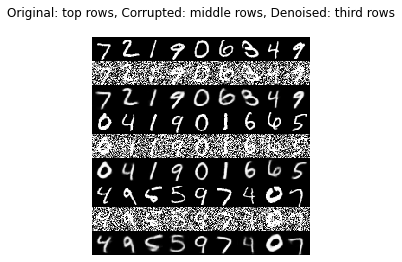

In [42]:
# Step 5 : Model evaluation and prediction

x_decoded = autoencoder.predict(x_test_noisy)

# 9 MNIST 자릿수의 이미지 세트 3개
# 첫 번째 행 - 원본 이미지
# 두 번째 행 - 노이즈로 인해 손상된 이미지
# 세 번째 행 - 노이즈 제거 이미지
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
# (27, 28, 28, 1) 
# (27, 28, 28, 1)
# (27, 28, 28, 1)


imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
print(imgs.shape) # (9, 9, 28, 28) 
                  # 3행씩 3줄 // 9개의 숫자

imgs = np.vstack(np.split(imgs, rows, axis=1)) # 3열씩 잘라서 붙이는 이유가 뭐야?
print(imgs.shape) # (27, 3, 28, 28)

imgs = imgs.reshape((rows * 3, -1, image_size, image_size)) # 다시 나누는 이유는 뭐야?
print(imgs.shape) # (9, 9, 28, 28)

imgs = np.vstack([np.hstack(i) for i in imgs])
print(imgs.shape) # (252, 252)

imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original: top rows, '
          'Corrupted: middle rows, '
          'Denoised: third rows\n')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('corrupted_and_denoised.png')
#Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [34]:
print(imgs.shape)

(252, 252)


In [37]:
imgs[4]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 169, 253,
       253, 253, 253, 253, 253, 218,  30,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  38, 254, 109,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  61,   3,  42, 118, 193, 118, 118,
        61,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   7, 150, 252, 252, 125,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  12,  41, 146, 146,  48,   0,   

In [44]:
print(x_test[:num].shape)
print(x_test_noisy[:num].shape)
print(x_decoded[:num].shape)

(27, 28, 28, 1)
(27, 28, 28, 1)
(27, 28, 28, 1)


# Review


동일한 MNIST 데이터 세트를 사용하여 임의 노이즈를 추가하여 손상된 이미지를 시뮬레이션할 수 있습니다.<br> 추가된 노이즈는 이미지 평균과 이미지의 표준 편차를 갖는 가우스 분포입니다.<br> 랜덤 노이즈를 추가하면 픽셀 데이터가 0보다 작거나 1보다 큰 잘못된 값으로<br> 푸시될 수 있으므로 픽셀 값은 [0.1, 1.0] 범위로 잘립니다.

훈련에 필요한 epoch 수가 10개로 늘어났습니다.<br> 이는 충분한 파라미터 최적화를 허용하기 위한 것입니다.

그림 3.3.3은 이미지에서 이미지 및 이미지로 노이즈 수준이 증가할 때 DAE의 특정 수준의 견고성을 보여줍니다.<br> 이미지에서 DAE는 여전히 원본 이미지를 복구할 수 있습니다.<br> 그러나 이미지에서 두 번째 및 세 번째 세트의 4 및 5와 같은 몇 자리 숫자를 더 이상 올바르게 복구할 수 없습니다.

![image.png](attachment:image.png)

이 개념은 MNIST 자릿수로 시연되었지만 다른 신호에도 적용할 수 있습니다.